In [150]:
import cv2 as cv
from ultralytics import YOLO
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [151]:
classNames = ['license-plate']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
               'U', 'V', 'W', 'X', 'Y', 'Z']
model = YOLO(r'models/best.pt')
detect_chars = tf.keras.models.load_model(r'models/model128.h5')
image = cv.imread(r"/home/herfandi/NN/Apps/image_test.jpg")


In [152]:
def display(img_, title=''):
    img = cv.cvtColor(img_, cv.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    

In [153]:
image = cv.resize(image, (int(image.shape[1]*.4),int(image.shape[0]*.4)))
results = model(image)[0]


0: 640x480 1 license-plate, 27.1ms
Speed: 2.8ms preprocess, 27.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


In [154]:
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

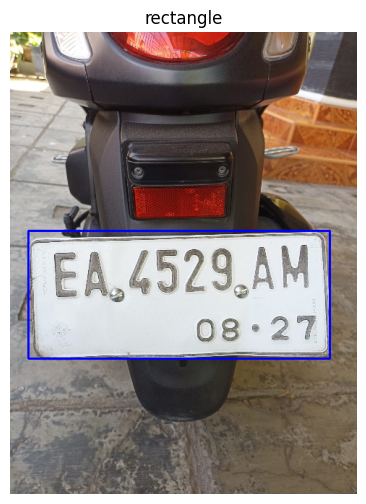

In [155]:
rects = cv.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
cv.imwrite('/home/herfandi/NN/Apps/process/01_rectangle.jpg',rects)
display(rects, 'rectangle')



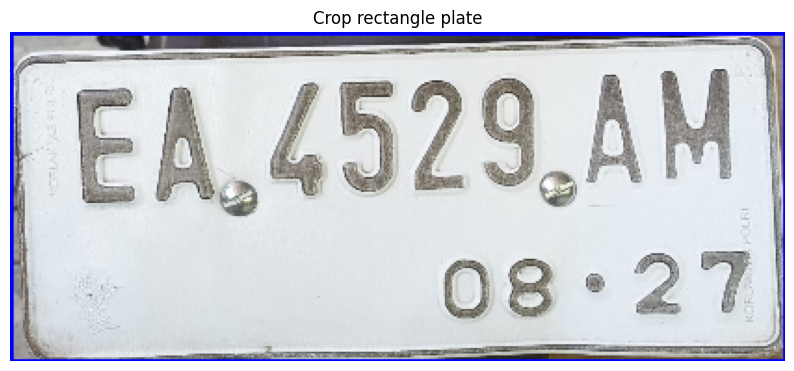

In [156]:
croppedimg = image[int(y1):int(y2), int(x1): int(x2)]
cv.imwrite('/home/herfandi/NN/Apps/process/02_Crop_rectangle.jpg', croppedimg)
display(croppedimg, 'Crop rectangle plate')

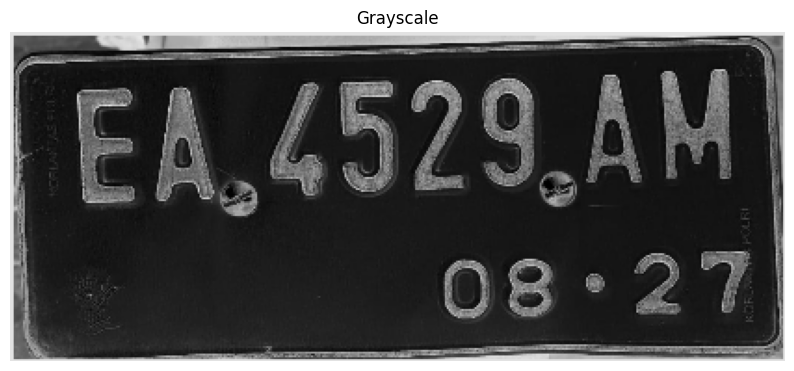

In [157]:
gray = cv.cvtColor(croppedimg, cv.COLOR_BGR2GRAY)
if np.mean(gray) > 128:
            # white plate
    gray = 255 - gray
cv.imwrite('/home/herfandi/NN/Apps/process/03_Grayscale.jpg', gray)
display(gray, 'Grayscale')    

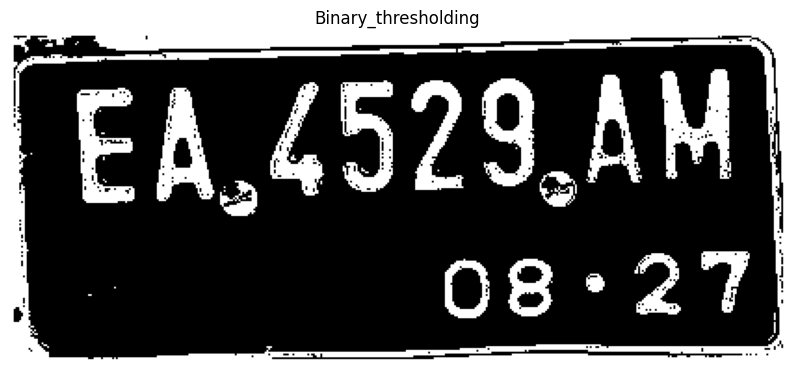

In [158]:
_,binary = cv.threshold(gray, 200, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
cv.imwrite('/home/herfandi/NN/Apps/process/04_Binary_thresholding.jpg', binary)
display(binary, 'Binary_thresholding')

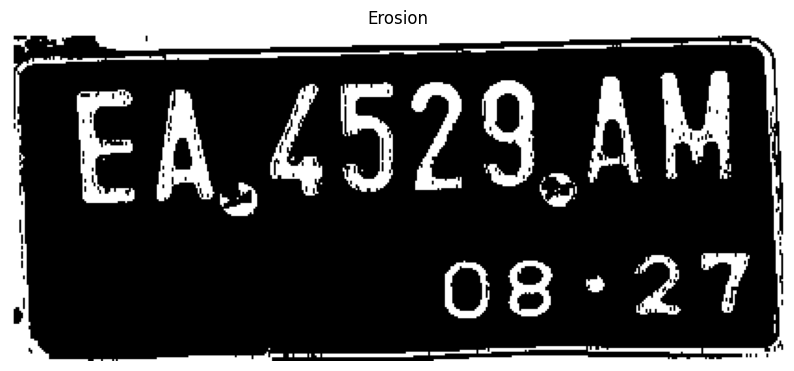

In [159]:
erode = cv.erode(binary, (3,3))
cv.imwrite('/home/herfandi/NN/Apps/process/05_Erosion.jpg', erode)
display(erode, 'Erosion')

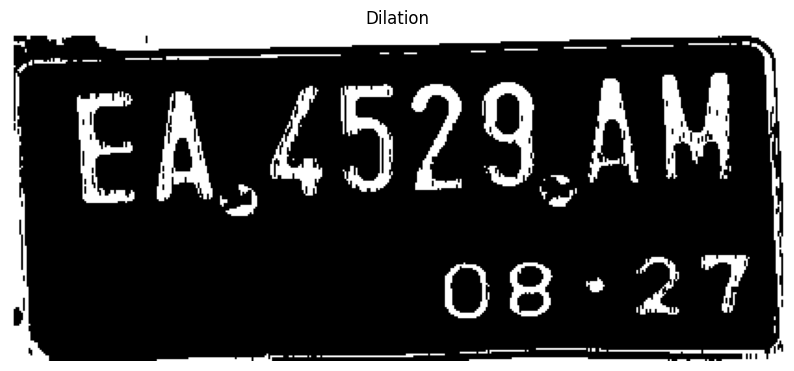

In [160]:
dilate = cv.erode(erode, (3,3))
cv.imwrite('/home/herfandi/NN/Apps/process/06_Dilation.jpg', dilate)
display(dilate, 'Dilation')   

In [161]:
contours, _ = cv.findContours(erode, cv.RETR_TREE , cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda contour: cv.boundingRect(contour)[0])
image_copy = croppedimg.copy()

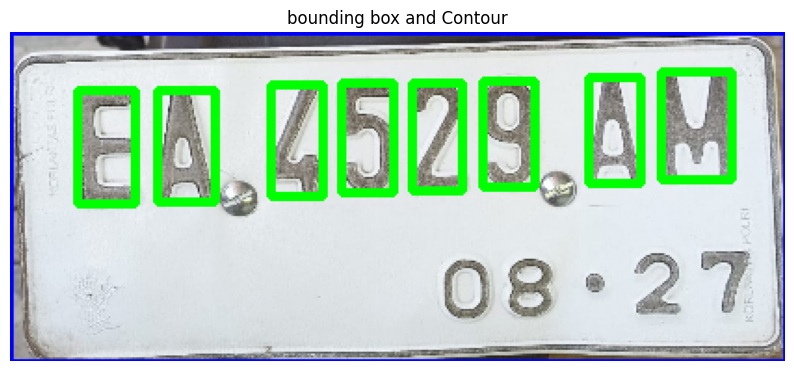

In [166]:
platno=[]
index=0
digit_w, digit_h = 40, 40
for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        ratio = h/w
        if h/croppedimg.shape[0]>=0.3 and 1<=ratio<=3.5:
            platno.append(index)
            cv.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,0),3)
            cv.imwrite('/home/herfandi/NN/Apps/process/07_Contour.jpg',image_copy )
#           print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        index += 1
        
num_plate = []
display(image_copy, 'bounding box and Contour')

In [163]:
for index in platno:
        x,y,w,h = cv.boundingRect(contours[index])
        cv.rectangle(croppedimg, (x, y), (x + w, y + h), (0, 0, 255), 2)
        # potong citra karakter
        char_crop = cv.cvtColor(dilate[y:y+h,x:x+w], cv.COLOR_GRAY2BGR)
        # resize citra karakternya
        char_crop = cv.resize(char_crop, (digit_w, digit_h))
        img_array = tf.keras.preprocessing.image.img_to_array(char_crop)

        # agar shape menjadi [1, h, w, channels]
        img_array = tf.expand_dims(img_array, 0)

        # buat prediksi
        predictions = detect_chars.predict(img_array)
        score = tf.nn.softmax(predictions[0]) 

        num_plate.append(class_names[np.argmax(score)])


    # Gabungkan string pada list
plate_number = ''
for a in num_plate:
        plate_number += a




1/1 [==============================] - 0s 16ms/step


Confidence ---> 0.95
Class name --> license-plate


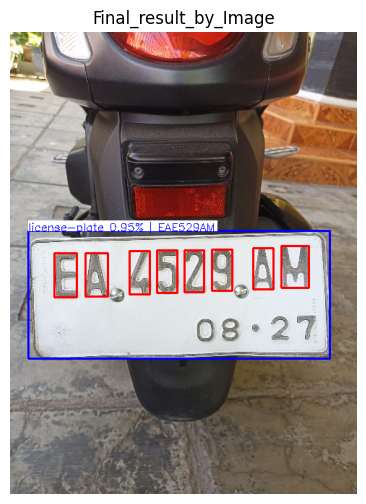

In [164]:
confidence = math.ceil((box.conf[0]*100))/100
print("Confidence --->",confidence)

    # Get class name
cls = int(box.cls[0])
print("Class name -->", classNames[cls])

    # Prepare text for display
text = f'{classNames[cls]} {confidence}% | {plate_number}'

    # Object details
org = [x1, y1]
font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (255, 0, 0)
thickness = 1

    # Add background for text
(text_width, text_height) = cv.getTextSize(text, font, fontScale=fontScale, thickness=thickness)[0]
box_coords = ((org[0], org[1]), (org[0] + text_width + 2, org[1] - text_height - 2))
cv.rectangle(image, box_coords[0], box_coords[1], (255, 255, 255), cv.FILLED)

    # Put text on image
cv.putText(image, text, org, font, fontScale, color, thickness)


    # Save the image with text and bounding box
cv.imwrite('/home/herfandi/NN/Apps/process/08_Final_result_by_Image.jpg', image)
display(image, 'Final_result_by_Image')